In [1]:
import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f #isnull, when, count, col, substring, date_format
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

# starts the spark session that uses: 4 cores, sql and rdd contexts
# note: this spark session only uses the local machine
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

# a sparkcontext which makes rdds
#sc = spark.sparkContext

Electric bikes are still new and changing https://www.lyft.com/bikes/bay-wheels/service-log
studies on bike share effects on cities: https://www.outsideonline.com/2136406/do-bike-share-systems-actually-work

#### Problems:  
docked bike vs classic bike? probably the same  
electric is mostly null (can't do a lot of station specific info)  
    may be able to swing altitude estimates with nearest station?  
member info not public

#### combo info:  
weather (daily? hourly?)  
-precipitation, temperature, air pollution (?)  
station altitude?  
start/stop distance  
traffic?  
subway/bus crowded measure?  
neighborhood income?

#### overview (non ML):  
"greenness" of a city?  
obesity of a city?  
amount of bike lanes? (advanced: bike related laws)  

#### target:  
electric vs non-electric  
returned to docking station vs not (electric only I believe)

In [9]:
ch_sdf = spark.read.csv('data/CH/202012-divvy-tripdata.csv', header=True)

ch_sdf.groupBy('rideable_type').count().show()

+-------------+-----+
|rideable_type|count|
+-------------+-----+
|  docked_bike|13004|
|electric_bike|47953|
| classic_bike|70616|
+-------------+-----+



In [3]:
ch_sdf = spark.read.csv('data/SF/202012-baywheels-tripdata.csv', header=True)

ch_sdf.groupBy('rideable_type').count().show()

+-------------+-----+
|rideable_type|count|
+-------------+-----+
|  docked_bike|  638|
|electric_bike|74710|
| classic_bike|31074|
+-------------+-----+



In [9]:
ch_sdf.show(300)

+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|           end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+------------------+------------------+-------------+
|70B6A9A437D4C30D| classic_bike|2020-12-27 12:44:29|2020-12-27 12:55:06|Aberdeen St & Jac...|           13157|Desplaines St & K...|  TA1306000003|       41.87772613|      -87.65478743|      41.888716036|    -87.6444478533|       member|
|158A465D4E74C54A|electric_bike|2020-12-18 17:37:15|

## minimum viable product

For our list of all station ids and lat/long: around 450 in total, with just electric only about 330 (?).

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('data/SF/202102-baywheels-tripdata.csv')

# drop columns we don't need
df = df.drop(columns=['ride_id', 'start_station_name', 'start_lat', 'start_lng', 'end_station_name'])

# drop rows w/o lat/long coordinates
df = df[df['end_lat'].notna()]

# drop non-electric bikes
df = df[df['rideable_type'] == 'electric_bike']
df.reset_index(drop=True)
df = df.drop(columns='rideable_type')

df

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual
...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual


In [4]:
# RERUN THIS GUY if you need the station coordinates

# df of station lat/long indexed by station id

df_s_geo = df[['end_station_id', 'end_lat', 'end_lng']].groupby(by='end_station_id').agg(np.mean)

# example of how to get the lat/long out
df_s_geo.loc['SJ-R11'] #['BK-A3']

end_lat     37.320296
end_lng   -121.870042
Name: SJ-R11, dtype: float64

In [5]:
df_s_geo

,end_lat,end_lng
end_station_id,,
SF Depot,37.754747,-122.389859
SF I29-1,37.783534,-122.393190
SF-A19,37.805291,-122.437386
SF-A20,37.804529,-122.433590
SF-A27,37.804767,-122.403280
...,...,...
SJ-Q4,37.309038,-121.899941
SJ-Q5,37.311253,-121.896288
SJ-Q8,37.317154,-121.884850


In [6]:
stat_id = 'SJ-R11'

tuple([val for idx, val in df_s_geo.loc[stat_id].items()])

(37.32029552083334, -121.870041875)

In [9]:
# geopy: calculates distance between lat/long coordinates

station_1 = 'SJ-R11'
geo_1 = tuple([val for idx, val in df_s_geo.loc[station_1].items()])

station_2 = 'SF-A27'
geo_2 = tuple([val for idx, val in df_s_geo.loc[station_2].items()])

geodesic(geo_1, geo_2).km

71.49002813235485

In [10]:
def station_dist(row, input_geo):
    '''Returns the distance between an input coordinate set 
    and a row coordinate set.
    
    Applied to the station coordinate dataframe, can be used 
    to make a new column of distances from a specific point
    in space.
    '''
    
    # geopy uses lat/long tuples to calculate distance
    stat_geo = tuple([val for idx, val in row.items()])
    
    return geodesic(stat_geo, input_geo).km

In [11]:
def nearest_station(row, df):
    '''doc string'''
    
    # quick progress tracker
    if row.name%1000 == 0:
        print(round(row.name/78000, 3))
    
    # get row values (I don't know a better way to do this)
    # this row expects 7 columns specifically,
    # if df is changed beforehand the following lines will mess up
    row_vals = [val for idx, val in row.items()]
    
    # if statement to catch rows where bikes are already at a station
    if not pd.isna(row_vals[3]):
        return 0, row_vals[3]
    
    # get row lat/long
    row_geo = tuple(row_vals[4:6])
    
    # get distance to each station
    station_geo = df_s_geo.copy()
    station_geo['dist'] = station_geo.apply(station_dist, args=[row_geo], axis=1)
    
    # grab the minimum distance and station name
    min_id = station_geo['dist'].idxmin()
    min_dist = station_geo.at[min_id, 'dist']*1000
    
    # can return station name and distance (or just distance) in meters
    return min_dist, min_id

In [173]:
# IF YOU RUN THIS CELL, RERUN ABOVE TO CLEAR OUT TEST

input_geo = (37.32029692782224, -121.87006150286038)

df_s_geo['test'] = df_s_geo.apply(station_dist, args=[input_geo], axis=1)

df_s_geo

,end_lat,end_lng,test
end_station_id,,,
BK-A3,37.851376,-122.252523,67.937209
BK-A7,37.880222,-122.269592,71.461981
BK-B7,37.876573,-122.269528,71.107570
BK-C1,37.870407,-122.299676,71.883888
BK-C5,37.873558,-122.283093,71.421889
...,...,...,...
SJ-Q4,37.309028,-121.899970,2.931351
SJ-Q5,37.311260,-121.896297,2.532589
SJ-Q8,37.317262,-121.884959,1.362766


In [149]:
min_idx = df_s_geo['test'].idxmin()

min_idx

'SJ-R11'

In [152]:
df_s_geo.at[min_idx, 'test']

0.0

In [12]:
# The big computation

df['closest_dist'], df['closest_id'] = zip(*df.apply(nearest_station, args=[df], axis=1))

df

0.0
0.009
0.018
0.027
0.036
0.045
0.054
0.063
0.072
0.081
0.09
0.126
0.162
0.18
0.189
0.198
0.234
0.243
0.252
0.261
0.27
0.279
0.288
0.315
0.333
0.351
0.36
0.387
0.396
0.405
0.423
0.432
0.441
0.45
0.459
0.486
0.495
0.505
0.514
0.523
0.532
0.559
0.568
0.577
0.613
0.631
0.649
0.658
0.667
0.676
0.694
0.703
0.712
0.721
0.73
0.748
0.766
0.784
0.802
0.811
0.82
0.829
0.838
0.856
0.865
0.883
0.892
0.901
0.91
0.919
0.928
0.946
0.955
0.964
0.973
0.982
0.991


,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [13]:
df.to_csv('mvp.csv')

In [16]:
df = pd.read_csv('mvp.csv', index_col='Unnamed: 0')

df

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.780000,-122.420000,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.800000,-122.420000,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.790000,-122.430000,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.770000,-122.500000,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.770000,-122.490000,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,SF-F26,37.788206,-122.408450,member,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,SF-H30,37.783104,-122.388015,member,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,SF-N23,37.763738,-122.415542,member,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,SF-N23,37.763731,-122.415441,casual,0.000000,SF-N23


In [17]:
df.isnull().sum()

started_at              0
ended_at                0
start_station_id    27674
end_station_id      30805
end_lat                 0
end_lng                 0
member_casual           0
closest_dist            0
closest_id              0
dtype: int64

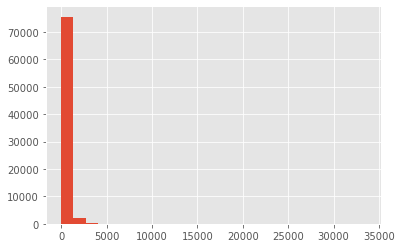

In [18]:
fig, ax = plt.subplots()

ax.hist(df['closest_dist'], bins=25);

In [19]:
#df[df['closest_dist'] > 0]

df.describe()

,end_lat,end_lng,closest_dist
count,78358.000000,78358.000000,78358.000000
mean,37.712401,-122.350448,195.340394
std,0.153959,0.187663,555.836108
min,37.240000,-122.511290,0.000000
25%,37.759119,-122.433242,0.000000
50%,37.770359,-122.417527,0.000000
75%,37.783641,-122.398209,199.906074
max,38.050000,-121.790000,33542.857395


In [42]:
df[df['closest_dist'] > 0].describe()

,end_lat,end_lng,closest_dist
count,30805.000000,30805.000000,30805.000000
mean,37.651721,-122.284449,496.883059
std,0.197460,0.244932,797.532508
min,37.240000,-122.510000,33.007335
25%,37.350000,-122.440000,156.880708
50%,37.760000,-122.410000,247.967367
75%,37.780000,-121.910000,511.963177
max,38.050000,-121.790000,33542.857395


In [44]:
df[df['closest_dist'] > 0]

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,NaN,37.78,-122.42,casual,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,NaN,37.80,-122.42,casual,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,NaN,37.79,-122.43,casual,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,NaN,37.77,-122.50,casual,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,NaN,37.77,-122.49,casual,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
109041,2021-02-03 08:38:22,2021-02-03 08:54:04,SF-K17,NaN,37.75,-122.46,member,1031.464989,SF-O12
109042,2021-02-25 09:59:31,2021-02-25 10:07:54,SF-K17,NaN,37.77,-122.47,member,403.160845,SF-J10
110571,2021-02-15 12:24:07,2021-02-15 12:28:54,SF-N23,NaN,37.75,-122.41,member,215.358834,SF-R24
110596,2021-02-20 19:27:46,2021-02-20 19:55:57,SF-N23,NaN,37.80,-122.39,member,567.660956,SF-D29


In [27]:
X = df.copy()

X['end_station_id'] = X['end_station_id'].apply(lambda x: 0 if pd.isna(x) else 1)

X['member_casual'] = X['member_casual'].apply(lambda x: 0 if x=='casual' else 1)

X

,started_at,ended_at,start_station_id,end_station_id,end_lat,end_lng,member_casual,closest_dist,closest_id
0,2021-02-12 12:16:25,2021-02-12 12:17:01,NaN,0,37.780000,-122.420000,0,182.572069,SF-I22
1,2021-02-28 17:27:12,2021-02-28 17:45:50,NaN,0,37.800000,-122.420000,0,406.725168,SF-C22
2,2021-02-28 18:09:53,2021-02-28 18:28:04,NaN,0,37.790000,-122.430000,0,228.747031,SF-E20
3,2021-02-28 18:29:57,2021-02-28 18:35:25,NaN,0,37.770000,-122.500000,0,623.700410,SF-J3
4,2021-02-28 18:07:04,2021-02-28 18:23:07,NaN,0,37.770000,-122.490000,0,727.194964,SF-J5
...,...,...,...,...,...,...,...,...,...
111056,2021-02-15 18:56:53,2021-02-15 19:09:02,SF-N23,1,37.788206,-122.408450,1,0.000000,SF-F26
111061,2021-02-01 18:03:30,2021-02-01 18:16:39,SF-B28,1,37.783104,-122.388015,1,0.000000,SF-H30
111063,2021-02-17 13:51:02,2021-02-17 13:59:08,SF-P26,1,37.763738,-122.415542,1,0.000000,SF-N23
111065,2021-02-28 08:47:29,2021-02-28 08:59:43,SF-K29-1,1,37.763731,-122.415441,0,0.000000,SF-N23


In [28]:
y = X['closest_dist']
X = X.drop(columns=['start_station_id', 'started_at', 'ended_at', 'closest_id'])

X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LinearRegression().fit(X_train, y_train)

In [29]:
yhat = model.predict(X_test)

# check supervised case study for metric and inference methods
mean_squared_error(y_test, yhat)

4.0342946770964487e-22

<BarContainer object of 5 artists>

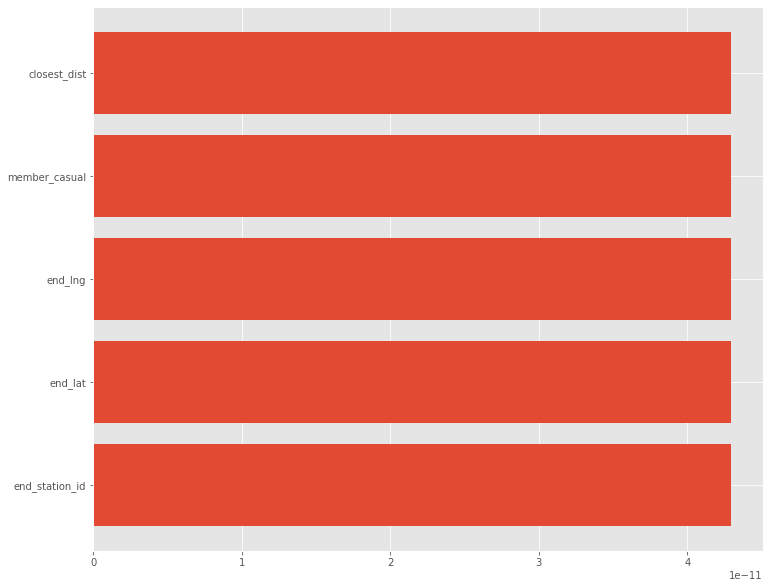

In [30]:
fix, ax = plt.subplots(figsize=(12,10))

ax.barh(X_train.columns, model.coef_[0])

scale inputs, make really basic model

add weather, add traffic

interpret model